In [2]:
import os; os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from koopmanlib.functions import *

In [6]:
import json
import sys

# Generate data

In [39]:
config_file = 'config_fhn.json'

In [40]:
data_path = 'results/fhn_pde/data'
weights_path = 'results/fhn_pde/weights'
figures_path = 'results/fhn_pde/figures'

In [41]:
with open(config_file, 'r') as f:
    config = json.load(f)['fhn_settings']

In [42]:
Nx = config['data_settings']['Nx']
n_init = config['data_settings']['n_init']
traj_len = config['data_settings']['traj_len']

In [43]:
n_psi_train = config['nn_settings']['n_psi_train']
target_dim = Nx*2
param_dim = 1
n_psi = 1 + target_dim + n_psi_train
dict_layer_size = config['nn_settings']['dict_layer_size']
K_layer_size = config['nn_settings']['K_layer_size']

In [44]:
x = np.linspace(-10,10,Nx)
t = np.arange(0, traj_len, 1)

In [45]:
from koopmanlib.target import FitzHughNagumoTarget

In [46]:
fhn_pde = FitzHughNagumoTarget(
            n_init=n_init,
            traj_len=traj_len,
            x=x,
            dt=1e-5,
            t_step=1e-3,
            dim=target_dim,
            param_dim=param_dim,
#             delta=4,
#             epsilon=3,
            param_input=1e3,
            seed_z=1,
            seed_param=123)

In [13]:
# data_z_curr, data_u, data_z_next = fhn_pde.generate_data()

In [18]:
data_dict = np.load(os.path.join(data_path, 'data_fhn_Nx_'+str(Nx)+'.npy'), allow_pickle=True)

In [19]:
data_z_curr = data_dict[()]['data_z_curr']
data_u = data_dict[()]['data_u']
data_z_next = data_dict[()]['data_z_next']

In [20]:
data_z_curr.shape

(49900, 20)

In [21]:
data_z_curr_reshape = data_z_curr.reshape(-1,n_init,target_dim)
data_z_curr_reshape_trans = np.transpose(data_z_curr_reshape, (1,0,2))

sample_idx = 1

In [62]:
# x_axis = x
# y_axis = np.arange(0, t.shape[0]-1, 1)
# plot_pde(x_axis=x_axis, 
#         y_axis=y_axis, 
#         data=data_z_curr_reshape_trans[sample_idx], 
#         Nx=Nx)

In [23]:
from sklearn.preprocessing import StandardScaler
scaler_z = StandardScaler()
scaler_z.fit(data_z_curr)

z_curr_normalized = scaler_z.transform(data_z_curr)
z_next_normalized = scaler_z.transform(data_z_next)

# After the prediction, we use inverse_transform to recover data.

# z_curr_recover = scaler_z.inverse_transform(z_curr_normalized)

# Build model

In [24]:
from koopmanlib.dictionary import PsiNN
from koopmanlib.param_solver import KoopmanParametricDLSolver

In [25]:
from tensorflow.keras.optimizers import Adam

In [26]:
dic_pk = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

In [47]:
solver_pk = KoopmanParametricDLSolver(target_dim=target_dim, 
                                      param_dim=param_dim, 
                                      n_psi=n_psi,
                                      dic=dic_pk)

In [48]:
# model_pk, model_K_u_pred_pk = solver_pk.generate_model(layer_sizes=[128,128])
model_pk, model_K_u_pred_pk = solver_pk.generate_model(layer_sizes=K_layer_size)

In [49]:
# model_pk.summary()

In [50]:
model_pk.load_weights('results/fhn_pde/v4_norm_psi_'+str(n_psi_train)+'_model_pk_fhn_Nx_'+str(Nx)+'.h5')

In [32]:
# model_pk.load_weights('results/fhn_pde/v3_norm_psi_'+str(n_psi_train)+'_model_pk_fhn_Nx_'+str(Nx)+'.h5')

# Prediction

In [51]:
n_init_test = 1
traj_len_test = 500

In [52]:
fhn_pde_test = FitzHughNagumoTarget(
            n_init=n_init_test,
            traj_len=traj_len_test,
            x=x,
            dt=1e-5,
            t_step=1e-3,
            dim=target_dim,
            param_dim=param_dim,
            param_input=1e3,
            seed_z=11,
            seed_param=11)

In [53]:
data_true_normalized, data_pred_pk_normalized, z_curr_ori = recover_prediction(target=fhn_pde_test,
                                                           scaler=scaler_z,
                                                           solver=solver_pk)

In [54]:
data_true_normalized.shape, data_pred_pk_normalized.shape, z_curr_ori.shape

((499, 20), (499, 20), (499, 20))

In [55]:
x_axis = x
y_axis = np.arange(0, data_true_normalized.shape[0], 1)

In [56]:
# plot_pde_comparison(x_axis=x_axis,
#                     y_axis=y_axis, 
#                     data_true=data_true_normalized, 
#                     data_pred=data_pred_pk_normalized,
#                     Nx=Nx)

In [57]:
ratio_pk_normalized = compute_diff_ratio_one_traj(data_true_normalized, 
                                    data_pred_pk_normalized)

In [58]:
data_pred_pk_recover = scaler_z.inverse_transform(data_pred_pk_normalized)

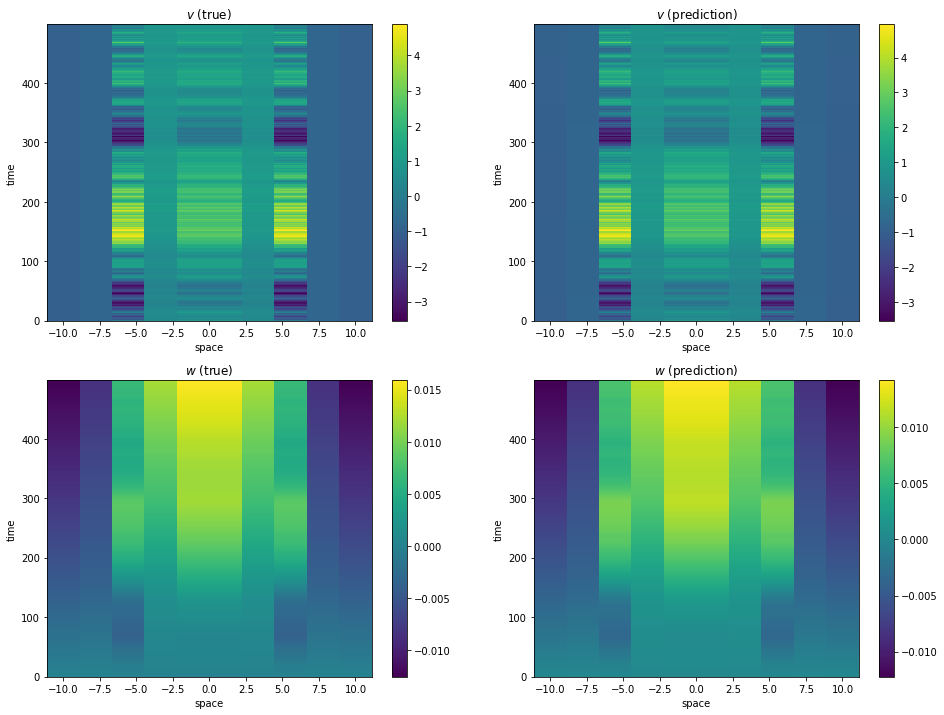

In [59]:
plot_pde_comparison(x_axis=x_axis,
                    y_axis=y_axis, 
                    data_true=z_curr_ori, 
                    data_pred=data_pred_pk_recover,
                    Nx=Nx)

In [63]:
ratio_pk_recover = compute_diff_ratio_one_traj(z_curr_ori, 
                                    data_pred_pk_recover)

In [64]:
data_pred_pk_normalized.shape

(499, 20)

# RBF + Ploynomial K (1, $u, u^2, u^3$)

In [65]:
from koopmanlib.dictionary import DicGaussianRBF

dic_rbf_fhn = DicGaussianRBF(rbf_number=n_psi_train, s=1/20)
# dic_rbf_fhn = DicGaussianRBF(rbf_number=30)



dic_rbf_fhn.build(z_curr_normalized)

from koopmanlib.param_solver import KoopmanActuatedDLSolver

solver_rbf = KoopmanActuatedDLSolver(dic=dic_rbf_fhn, 
                                     target_dim=target_dim, 
                                     param_dim=param_dim, 
                                     n_psi=n_psi, 
                                     basis_u_func=fhn_pde.basis_u_func)

model_rbf = solver_rbf.build_model()

model_rbf_opt = solver_rbf.opt_rbf_model(data_x=z_curr_normalized,
                                 data_u=data_u,
                                 data_y=z_next_normalized)

In [66]:
data_true_normalized, data_pred_rbf_normalized, z_curr_ori = recover_prediction(target=fhn_pde_test,
                                                           scaler=scaler_z,
                                                           solver=solver_rbf)

In [67]:
# # Normalized space
# x_axis = np.arange(0, Nx, 1)
# y_axis = np.arange(0, traj_len_test-1, 1)

# plot_pde_comparison(x_axis,
#                 y_axis, 
#                 data_true=data_true_normalized, 
#                 data_pred=data_pred_rbf_normalized, 
#                 Nx=Nx)

In [68]:
ratio_rbf_normalized = compute_diff_ratio_one_traj(data_true_normalized, data_pred_rbf_normalized)

In [69]:
# Original space
data_pred_rbf_recover = scaler_z.inverse_transform(data_pred_rbf_normalized)

In [70]:
# x_axis = np.arange(0, Nx, 1)
# y_axis = np.arange(0, traj_len_test-1, 1)
# plot_pde_comparison(x_axis, y_axis, data_true=z_curr_ori, data_pred=data_pred_rbf_recover, Nx=Nx)

In [71]:
data_pred_rbf_recover.shape

(499, 20)

In [72]:
ratio_rbf_recover = compute_diff_ratio_one_traj(z_curr_ori, 
                                    data_pred_rbf_recover)

# DL + Actuated K (1, $u, u^2, u^3$)

In [73]:
dic_dl_actK = PsiNN(layer_sizes=[128,128], n_psi_train=n_psi_train)

solver_dl_actK = KoopmanActuatedDLSolver(dic=dic_dl_actK, 
                                         target_dim=target_dim,
                                         param_dim=param_dim,
                                         n_psi=n_psi, 
                                         basis_u_func=fhn_pde.basis_u_func)

model_dl_actK = solver_dl_actK.build_model()

# solver_dl_actK.opt_nn_model(data_x=z_curr_normalized,
#                     data_u=data_u, 
#                     data_y=z_next_normalized, 
#                     zeros_data_y_train=zeros_data_z_next_train,
#                     epochs=30,
#                     batch_size=200,
#                     lr=0.0001,
#                     log_interval=20,
#                     lr_decay_factor=0.1)

In [74]:
# solver_dl_actK.model.save_weights('results/fhn_pde/norm_psi_'+str(n_psi_train)+'_model_dl_actK_fhn_Nx_'+str(Nx)+'.h5')

In [75]:
solver_dl_actK.model.load_weights('results/fhn_pde/norm_psi_'+str(n_psi_train)+'_model_dl_actK_fhn_Nx_'+str(Nx)+'.h5')

In [76]:
data_true_normalized, data_pred_dl_actK_normalized, z_curr_ori = recover_prediction(target=fhn_pde_test,
                                                           scaler=scaler_z,
                                                           solver=solver_dl_actK)

In [77]:
# # Normalized space
# x_axis = np.arange(0, Nx, 1)
# y_axis = np.arange(0, traj_len_test-1, 1)

# plot_pde_comparison(x_axis,
#                 y_axis, 
#                 data_true=data_true_normalized, 
#                 data_pred=data_pred_dl_actK_normalized, 
#                 Nx=Nx)

In [78]:
ratio_dl_actK_normalized = compute_diff_ratio_one_traj(data_true_normalized, data_pred_dl_actK_normalized)

In [79]:
# Original space
data_pred_dl_actK_recover = scaler_z.inverse_transform(data_pred_dl_actK_normalized)

In [80]:
# x_axis = np.arange(0, Nx, 1)
# y_axis = np.arange(0, traj_len_test-1, 1)
# plot_pde_comparison(x_axis, y_axis, data_true=z_curr_ori, data_pred=data_pred_dl_actK_recover, Nx=Nx)

In [81]:
ratio_dl_actK_recover = compute_diff_ratio_one_traj(z_curr_ori, 
                                    data_pred_dl_actK_recover)

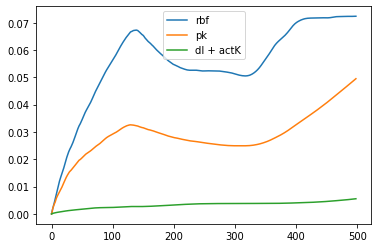

In [82]:
plt.plot(ratio_rbf_normalized, label='rbf')
plt.plot(ratio_pk_normalized, label='pk')
plt.plot(ratio_dl_actK_normalized, label='dl + actK')
plt.legend()

In [83]:
# plt.plot(ratio_rbf_recover, label='rbf')
# plt.plot(ratio_pk_recover, label='pk')
# plt.plot(ratio_dl_actK_recover, label='dl + actK')
# plt.legend()

# Average Prediction

In [84]:
np.random.seed(111)
n_test = 10
seed_z_list = np.random.randint(1,300, size=(n_test,))
seed_param_list = np.random.randint(1,300, size=(n_test,))

n_traj_test = 1

x_axis = x
y_axis = np.arange(0, traj_len_test-1, 1)

In [88]:
# ratio_pk_list = []
# ratio_rbf_list = []
# ratio_dl_actK_list = []

# for seed_z, seed_param in zip(seed_z_list, seed_param_list):
#     fhn_pde_test = FitzHughNagumoTarget(
#             n_init=n_init_test,
#             traj_len=traj_len_test,
#             x=x,
#             dt=1e-5,
#             t_step=1e-3,
#             dim=target_dim,
#             param_dim=param_dim,
#             param_input=1e3,
#             seed_z=seed_z,
#             seed_param=seed_param)
    
#     data_true_normalized, data_pred_pk_normalized, z_curr_ori = recover_prediction(target=fhn_pde_test,
#                                                            scaler=scaler_z,
#                                                            solver=solver_pk)
    
#     data_true_normalized, data_pred_rbf_normalized, z_curr_ori = recover_prediction(target=fhn_pde_test,
#                                                            scaler=scaler_z,
#                                                            solver=solver_rbf)
    
#     data_true_normalized, data_pred_dl_actK_normalized, z_curr_ori = recover_prediction(target=fhn_pde_test,
#                                                            scaler=scaler_z,
#                                                            solver=solver_dl_actK)
    
#     data_pred_pk_recover = scaler_z.inverse_transform(data_pred_pk_normalized)
#     data_pred_rbf_recover = scaler_z.inverse_transform(data_pred_rbf_normalized)
#     data_pred_dl_actK_recover = scaler_z.inverse_transform(data_pred_dl_actK_normalized)


    
#     ratio_pk_recover = compute_diff_ratio_one_traj(z_curr_ori, data_pred_pk_recover)
#     ratio_rbf_recover = compute_diff_ratio_one_traj(z_curr_ori, data_pred_rbf_recover)
#     ratio_dl_actK_recover = compute_diff_ratio_one_traj(z_curr_ori, data_pred_dl_actK_recover)



#     ratio_pk_list.append(ratio_pk_recover)
#     ratio_rbf_list.append(ratio_rbf_recover)
#     ratio_dl_actK_list.append(ratio_dl_actK_recover)
    
# #     plt.plot(ratio_rbf_recover, label='rbf')
# #     plt.plot(ratio_pk_recover, label='pk')
# #     plt.plot(ratio_dl_actK_recover, label='dl + actK')
# #     plt.legend()
# #     plt.show()

# ratio_pk_list = np.asarray(ratio_pk_list)
# ratio_rbf_list = np.asarray(ratio_rbf_list)
# ratio_dl_actK_list = np.asarray(ratio_dl_actK_list)

# def compute_stat_info(data):
#     data_mean = np.mean(data, axis=0)
#     data_std = np.std(data, axis=0)
#     mean_plus_std = data_mean + data_std
#     mean_minus_std = data_mean - data_std
#     return data_mean, data_std, mean_plus_std, mean_minus_std

# mean_pk, std_pk, mean_plus_pk, mean_minus_pk = compute_stat_info(ratio_pk_list)
# mean_rbf, std_rbf, mean_plus_rbf, mean_minus_rbf = compute_stat_info(ratio_rbf_list)
# mean_dl_actK, std_dl_actK, mean_plus_dl_actK, mean_minus_dl_actK = compute_stat_info(ratio_dl_actK_list)

# label_font = 16
# ticks_font = 16
# legend_font = 16
# linewidth = 2

# t_axis = np.arange(0, traj_len_test-1, 1)

# plt.plot(mean_rbf, label='M4-RBF', color='darkorange', linewidth=linewidth)
# plt.fill_between(t_axis, mean_minus_rbf, mean_plus_rbf, color='navajowhite', alpha=0.5)

# plt.plot(mean_dl_actK, label='M4-NN', color='forestgreen', linewidth=linewidth)
# plt.fill_between(t_axis, mean_minus_dl_actK, mean_plus_dl_actK, color='darkseagreen', alpha=0.5)


# plt.plot(mean_pk, label='Ours', color='steelblue', linewidth=linewidth)
# plt.fill_between(t_axis, mean_minus_pk, mean_plus_pk, color='lightsteelblue', alpha=0.5)

# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)

# plt.xlabel(r'$n$', fontsize=28)
# plt.ylabel('Error', fontsize=28)
# plt.legend(fontsize=14)

# plt.savefig('results/fhn_pde/figures/fhn_error_Nx'+str(Nx)+'.png', dpi=200, bbox_inches='tight')
# plt.savefig('results/fhn_pde/figures/fhn_error_Nx'+str(Nx)+'.pdf', dpi=200, bbox_inches='tight')

In [105]:
# dict_error = {'pk': ratio_pk_list,
#              'rbf': ratio_rbf_list,
#              'dl':ratio_dl_actK_list}

In [72]:
# np.save('results/fhn_pde/data/error_dict.npy', dict_error)

# Load data and plot

In [85]:
n_init_test = 1
traj_len_test = 500
Nx = 10

In [86]:
dict_error_load = np.load('results/fhn_pde/data/error_dict.npy', allow_pickle=True)

In [87]:
ratio_pk_list = dict_error_load[()]['pk']
ratio_rbf_list = dict_error_load[()]['rbf']
ratio_dl_actK_list = dict_error_load[()]['dl']

In [88]:
def compute_stat_info(data):
    data_mean = np.mean(data, axis=0)
    data_std = np.std(data, axis=0)
    mean_plus_std = data_mean + data_std
    mean_minus_std = data_mean - data_std
    return data_mean, data_std, mean_plus_std, mean_minus_std

In [89]:
mean_pk, std_pk, mean_plus_pk, mean_minus_pk = compute_stat_info(ratio_pk_list)
mean_rbf, std_rbf, mean_plus_rbf, mean_minus_rbf = compute_stat_info(ratio_rbf_list)
mean_dl_actK, std_dl_actK, mean_plus_dl_actK, mean_minus_dl_actK = compute_stat_info(ratio_dl_actK_list)

In [90]:
label_font = 16
ticks_font = 16
legend_font = 16
linewidth = 2

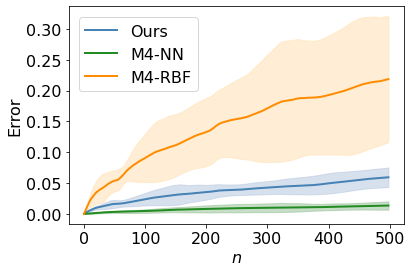

In [91]:
t_axis = np.arange(0, traj_len_test-1, 1)


plt.plot(mean_pk, label='Ours', color='steelblue', linewidth=linewidth)
plt.fill_between(t_axis, mean_minus_pk, mean_plus_pk, color='lightsteelblue', alpha=0.5)

plt.plot(mean_dl_actK, label='M4-NN', color='forestgreen', linewidth=linewidth)
plt.fill_between(t_axis, mean_minus_dl_actK, mean_plus_dl_actK, color='darkseagreen', alpha=0.5)


plt.plot(mean_rbf, label='M4-RBF', color='darkorange', linewidth=linewidth)
plt.fill_between(t_axis, mean_minus_rbf, mean_plus_rbf, color='navajowhite', alpha=0.5)

plt.xticks(fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)

plt.xlabel(r'$n$', fontsize=label_font)
plt.ylabel('Error', fontsize=label_font)
plt.legend(fontsize=legend_font, loc=(0.03,0.61))


# plt.savefig('results/fhn_pde/figures/fhn_error_Nx'+str(Nx)+'.png', dpi=200, bbox_inches='tight')
# plt.savefig('results/fhn_pde/figures/fhn_error_Nx'+str(Nx)+'.pdf', dpi=200, bbox_inches='tight')